### Final tabular operations in preparation for adding data to web map
In this notebook we'll read back in the utah_riparian_birds.geojson and perform a few additional tabular operations that will aid in making our data look a bit nicer in the final web map. We'll also verify that our streams and occurrennces in crs WGS84 so they play nicely with our web map.

Notebook by Zac Stanley for New Maps Plus - MAP674

#### Import python libraries

In [1]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# change default max columns
pd.set_option('display.max_rows', None)

# change default figure size
plt.rcParams['figure.figsize'] = (15,12)

#### Import local datasets 

In [2]:
#utah major streams
utah_major_streams = gpd.read_file ("./data/utah_major_streams.geojson")

# utah_riparian_birds
utah_riparian_birds = gpd.read_file("./data/utah_riparian_birds.geojson", encoding='UTF-8')

#### Check CRS of each object

In [3]:
utah_riparian_birds.crs

{'init': 'epsg:4326'}

In [4]:
utah_major_streams.crs

{'init': 'epsg:4326'}

#### Inspect utah_riparian_birds object

In [5]:
utah_riparian_birds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   field_1                 598 non-null    int64   
 1   individualCount         598 non-null    object  
 2   occurrenceStatus        598 non-null    object  
 3   year                    598 non-null    int64   
 4   month                   598 non-null    int64   
 5   day                     598 non-null    int64   
 6   stateProvince           598 non-null    object  
 7   county                  598 non-null    object  
 8   locality                598 non-null    object  
 9   decimalLatitude         598 non-null    float64 
 10  decimalLongitude        598 non-null    float64 
 11  scientificName          598 non-null    object  
 12  vernacularName          598 non-null    object  
 13  verbatimScientificName  598 non-null    object  
 14  geometry          

#### Convert month column to string

In [6]:
utah_riparian_birds['month'] = utah_riparian_birds['month'].apply(str)

#### Replace month number with month name in month column

In [7]:
# 1 with January, 2 with February and so on
utah_riparian_birds['month'].replace({'1': 'January', '2': 'February','3': 'March','4': 'April','5': 'May',
'6': 'June','7': 'July','8': 'August','9': 'September','10': 'October','11': 'November','12': 'December'},
inplace=True)

#### Verify the number string were replaced with name string

In [8]:
utah_riparian_birds.head()

,field_1,individualCount,occurrenceStatus,year,month,day,stateProvince,county,locality,decimalLatitude,decimalLongitude,scientificName,vernacularName,verbatimScientificName,geometry
0,117,4.0,PRESENT,2019,February,13,Utah,Washington,Cottonwood Cove Park,37.0906,-113.614,"Passerculus sandwichensis (J.F.Gmelin, 1789)",Savannah Sparrow,Passerculus sandwichensis,POINT (-113.61400 37.09060)
1,631,1.0,PRESENT,2019,April,2,Utah,Washington,Zion NP--Canyon Overlook Trail,37.2134,-112.942,"Thryomanes bewickii (Audubon, 1827)",Bewick's Wren,Thryomanes bewickii,POINT (-112.94200 37.21340)
2,2626,5.0,PRESENT,2019,May,4,Utah,Washington,Confluence Park,37.2053,-113.288,"Thryomanes bewickii (Audubon, 1827)",Bewick's Wren,Thryomanes bewickii,POINT (-113.28800 37.20530)
3,3099,1.0,PRESENT,2019,April,12,Utah,Utah,Bartholomew Park,40.1493,-111.558,"Bubo virginianus (Gmelin, 1788)",Great Horned Owl,Bubo virginianus,POINT (-111.55800 40.14930)
4,3160,1.0,PRESENT,2019,July,10,Utah,Kane,"Orderville Canyon, Glendale US-UT",37.3325,-112.863,"Catherpes mexicanus (Swainson, 1829)",Canyon Wren,Catherpes mexicanus,POINT (-112.86300 37.33250)


### Get additional attribute information for our web map
I would like to add the stream/river name from our Utah major streams to give more context to the points in the web map. To accomplish this we can buffer utah_riparian_birds to 300 ft and join them spatially with the utah_major_streams

#### Re-project points and streams again for spatial operations where distances are calculated

In [9]:
# set a variable with parameters for USA Contiguous Equidistant
project_params  = '+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

# reproject and assign to new variables
streams_prj = utah_major_streams.to_crs(project_params)
birds_prj = utah_riparian_birds.to_crs(project_params)

#### Buffer occurrence points

In [10]:
# buffer occurrences to 300 ft as this was the distance this GeoDataFrame was originally created from
# we know the units are in meters so.......300 feet = 91.44 meters
birds_prj['buffer'] = birds_prj.buffer(91.44)

#### Inspect data

In [11]:
birds_prj['buffer'].head()

0    POLYGON ((-1548681.921 -61920.502, -1548682.36...
1    POLYGON ((-1487771.846 -59722.682, -1487772.28...
2    POLYGON ((-1517966.214 -54904.230, -1517966.65...
3    POLYGON ((-1312137.111 239794.880, -1312137.55...
4    POLYGON ((-1478483.450 -48015.680, -1478483.89...
Name: buffer, dtype: geometry

#### Make new buffered column the active geometry

In [12]:
birds_prj = birds_prj.set_geometry('buffer')

# check what column geometry is referencing
print(birds_prj.geometry.name) # buffer

buffer


#### Plot buffered occurrences and streams

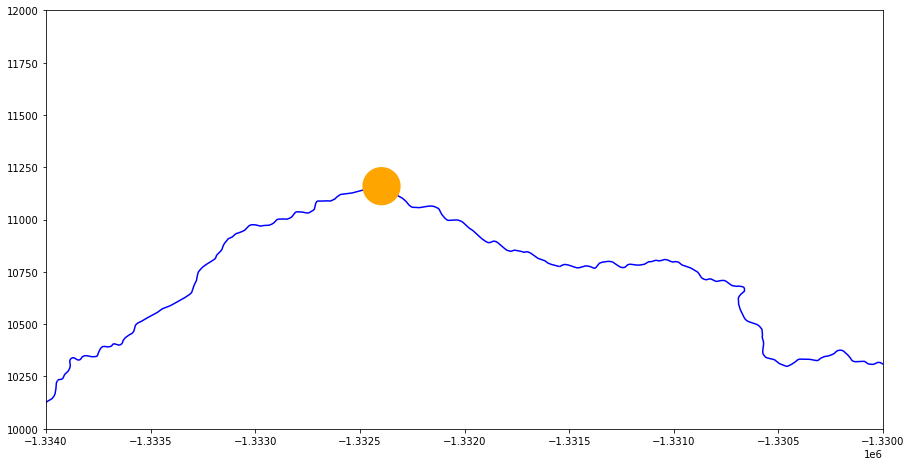

In [13]:
# verify that major streams now have buffer
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

birds_prj.plot(ax=ax, color='orange', zorder=2, markersize=20);
streams_prj.plot(ax=ax, color='blue', zorder=1);

# modify limits to check that buffers are displayed, confirmed
ax.set(xlim=(-1334000,-1330000), ylim=(10000,12000));

#### Spatially join stream attributes to buffered points

In [14]:
# join type argument 'how' to left to keep only existing points extratced from our previous buffer operation
birds_stream_names = gpd.sjoin(birds_prj, streams_prj, how='left', op='intersects')

#### Verify object type

In [15]:
type(birds_stream_names)

geopandas.geodataframe.GeoDataFrame

#### Inspect the object

In [16]:
birds_stream_names.sample()

,field_1,individualCount,occurrenceStatus,year,month,day,stateProvince,county,locality,decimalLatitude,...,WBArea_Per,FType,FType_Text,FCode,FCode_Text,Enabled,InUtah,IsMajor,Submerged,SHAPE_Leng
364,622871,1.0,PRESENT,2019,May,15,Utah,Utah,"1023 Provo River Parkway, Provo, Utah, US (40....",40.3388,...,None,460,Stream/River,46006,Stream/River - Perennial,None,1,1,0,0.00982


In [17]:
birds_stream_names.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 709 entries, 0 to 597
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   field_1                 709 non-null    int64   
 1   individualCount         709 non-null    object  
 2   occurrenceStatus        709 non-null    object  
 3   year                    709 non-null    int64   
 4   month                   709 non-null    object  
 5   day                     709 non-null    int64   
 6   stateProvince           709 non-null    object  
 7   county                  709 non-null    object  
 8   locality                709 non-null    object  
 9   decimalLatitude         709 non-null    float64 
 10  decimalLongitude        709 non-null    float64 
 11  scientificName          709 non-null    object  
 12  vernacularName          709 non-null    object  
 13  verbatimScientificName  709 non-null    object  
 14  geometry          

#### Drop uneccessary columns

In [18]:
birds_stream_names.drop(['OBJECTID','Permanent_','FDate','Resolution', 'GNIS_ID','LengthKM','ReachCode','buffer', 'FlowDir',
                         'WBArea_Per','FType','FType_Text','FCode','FCode_Text','Enabled','InUtah', 'IsMajor', 'Submerged',
                         'SHAPE_Leng'], axis=1,inplace=True)

#### Inspect the object again to verify drop fields
We want to keep 'GNIS_Name' field for display in web map

In [19]:
birds_stream_names.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 709 entries, 0 to 597
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   field_1                 709 non-null    int64   
 1   individualCount         709 non-null    object  
 2   occurrenceStatus        709 non-null    object  
 3   year                    709 non-null    int64   
 4   month                   709 non-null    object  
 5   day                     709 non-null    int64   
 6   stateProvince           709 non-null    object  
 7   county                  709 non-null    object  
 8   locality                709 non-null    object  
 9   decimalLatitude         709 non-null    float64 
 10  decimalLongitude        709 non-null    float64 
 11  scientificName          709 non-null    object  
 12  vernacularName          709 non-null    object  
 13  verbatimScientificName  709 non-null    object  
 14  geometry          

#### Change geometry reference back to 'geometry'

In [20]:
birds_stream_names = birds_stream_names.set_geometry('geometry')

# check what column geometry is referencing
print(birds_stream_names.geometry.name) # bufferbirds_prj = birds_prj.set_geometry('geometry')

geometry


#### Plot bird_stream_names

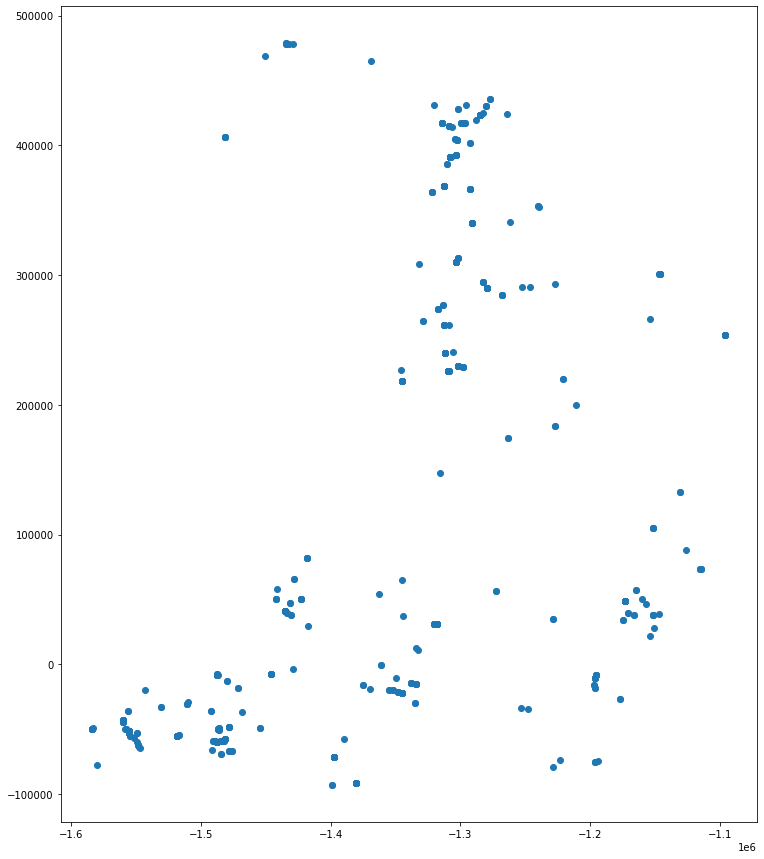

In [21]:
birds_stream_names.plot(figsize=(15,15));

### Prepare final data for web mapping

#### Verify crs of birds_stream_names

In [22]:
birds_stream_names.crs

'+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

#### Re-project birds_stream_names to WGS84

In [23]:
birds_stream_names_4326 = birds_stream_names.to_crs('+proj=longlat +datum=WGS84 +no_defs')

#### Verify crs

In [24]:
birds_stream_names_4326.crs

'+proj=longlat +datum=WGS84 +no_defs'

#### Inspect geometry colum for lat lon's

In [25]:
birds_stream_names_4326.sample()

,field_1,individualCount,occurrenceStatus,year,month,day,stateProvince,county,locality,decimalLatitude,decimalLongitude,scientificName,vernacularName,verbatimScientificName,geometry,index_right,GNIS_Name
422,706851,1.0,PRESENT,2019,May,7,Utah,San Juan,Bullet Canyon--Jailhouse Spring & Ruin,37.4374,-110.013,"Catherpes mexicanus (Swainson, 1829)",Canyon Wren,Catherpes mexicanus,POINT (-110.01300 37.43740),7307,None


#### Write final file to geoJSON

In [26]:
birds_stream_names_4326.to_file("./data/birds_stream_names_4326.geojson", driver='GeoJSON')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: './data/birds_stream_names_4326.geojson'